In [72]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D
from sklearn.metrics.pairwise import cosine_similarity

In [73]:
# Loading dataset
df = pd.read_csv('dataset.csv')

In [74]:
df.head()

,city,activity,rating,price,link,image_url,location\r,description
0,New York,SUMMIT One Vanderbilt Tickets,4.7,63.57,/attractions/us/prcmokyuz7um-summit-one-vander...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,SUMMIT One Vanderbilt Tickets45 East 42nd Stre...,Digital art installations and views of New Yor...
1,New York,9/11 Memorial & Museum Admission,4.8,36.66,/attractions/us/prgstbyhf5aj-911-memorial-muse...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,9/11 Memorial & Museum Admission180 Greenwich ...,Chance to visit a memorial and museum thats de...
2,New York,New York CityPASS,4.5,198.23,/attractions/us/prj7dhkaezyz-new-york-city-pas...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,"New York CityPASSNew York, NY, 10036\r",A sightseeing pass to explore Big Apple attrac...
3,New York,One-hour Sightseeing Yacht Cruise,3.8,21.72,/attractions/us/prulfebtv6ii-one-hour-sightsee...,https://q-xx.bstatic.com/xdata/images/xphoto/3...,Departure pointPier 36 New York - Van Gogh Exh...,A narrated cruise with views of the Statue of ...
4,New York,SUMMIT One Vanderbilt Ticket,4.5,63.57,/attractions/us/pr3zhwuklbbp-summit-one-vander...,https://q-xx.bstatic.com/xdata/images/xphoto/3...,"Departure pointSUMMIT One Vanderbilt, 45 E 42n...",Opportunity to go on an immersive multisensory...


In [75]:
df = df.rename(columns={"location\r": 'location'})
df['link'] = 'https://www.booking.com/' + df['link'].astype(str)


In [76]:
df.head(2)

,city,activity,rating,price,link,image_url,location,description
0,New York,SUMMIT One Vanderbilt Tickets,4.7,63.57,https://www.booking.com//attractions/us/prcmok...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,SUMMIT One Vanderbilt Tickets45 East 42nd Stre...,Digital art installations and views of New Yor...
1,New York,9/11 Memorial & Museum Admission,4.8,36.66,https://www.booking.com//attractions/us/prgstb...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,9/11 Memorial & Museum Admission180 Greenwich ...,Chance to visit a memorial and museum thats de...


In [77]:
df.tail(2)

,city,activity,rating,price,link,image_url,location,description
8591,Louisville,Louisville Food and History Walking Tour of NuLu,4.7,171.08,https://www.booking.com//attractions/us/prbmao...,https://q-xx.bstatic.com/xdata/images/xphoto/3...,"Departure point636 E Main St, E Main St 636, E...",Explore Louisvilles chic NuLu District where v...
8592,Louisville,One-hour Louisville Zombie Scavenger Hunt,NaN,27.15,https://www.booking.com//attractions/us/prsd5g...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,"Departure point527 W Jefferson St, Downtown, L...",Smartphoneguided zombie scavenger hunt of Loui...


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8593 entries, 0 to 8592
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         8593 non-null   object 
 1   activity     8593 non-null   object 
 2   rating       3058 non-null   float64
 3   price        8593 non-null   float64
 4   link         8593 non-null   object 
 5   image_url    8593 non-null   object 
 6   location     8593 non-null   object 
 7   description  8593 non-null   object 
dtypes: float64(2), object(6)
memory usage: 537.2+ KB


In [79]:
df.describe()

,rating,price
count,3058.000000,8593.000000
mean,4.530412,271.026015
std,0.511078,496.660522
min,1.200000,6.790000
25%,4.400000,61.100000
50%,4.700000,126.960000
75%,4.900000,257.970000
max,5.000000,14935.250000


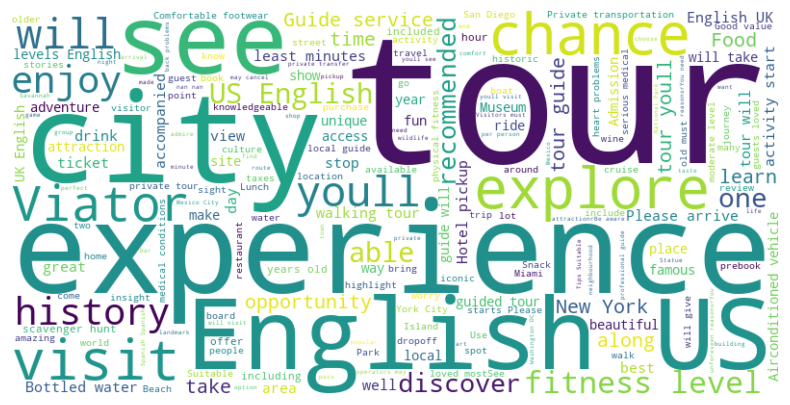

In [80]:
text = ' '.join(df['description'].astype(str).values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


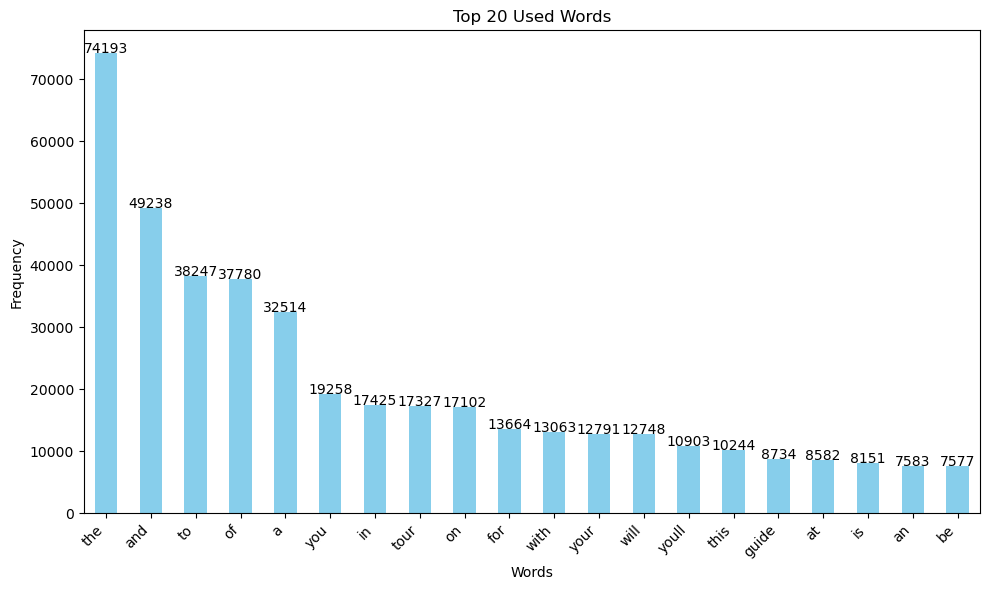

In [81]:
from collections import Counter
import re
words = df['description'].str.lower().str.findall(r'\b\w+\b').explode()

word_counts = Counter(words)
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

top20 = word_counts_df.head(20)
plt.figure(figsize=(10, 6))
bars = top20['count'].plot(kind='bar', color='skyblue')
plt.title('Top 20 Used Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

for i, count in enumerate(top20['count']):
    plt.text(i, count + 0.2, str(count), ha='center')

plt.tight_layout()
plt.show()

In [82]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def tokenize_sentences(text):
    return sent_tokenize(text)

# # Apply sentence tokenization to 'text_column'
# df['description'] = df['description'].apply(tokenize_sentences)

# # Explode the lists of sentences into separate rows, while keeping other columns intact
# df = df.explode('description').reset_index(drop=True)



In [83]:
df['description'] = df['description'].apply(remove_stopwords)

In [84]:
df.shape

(8593, 8)

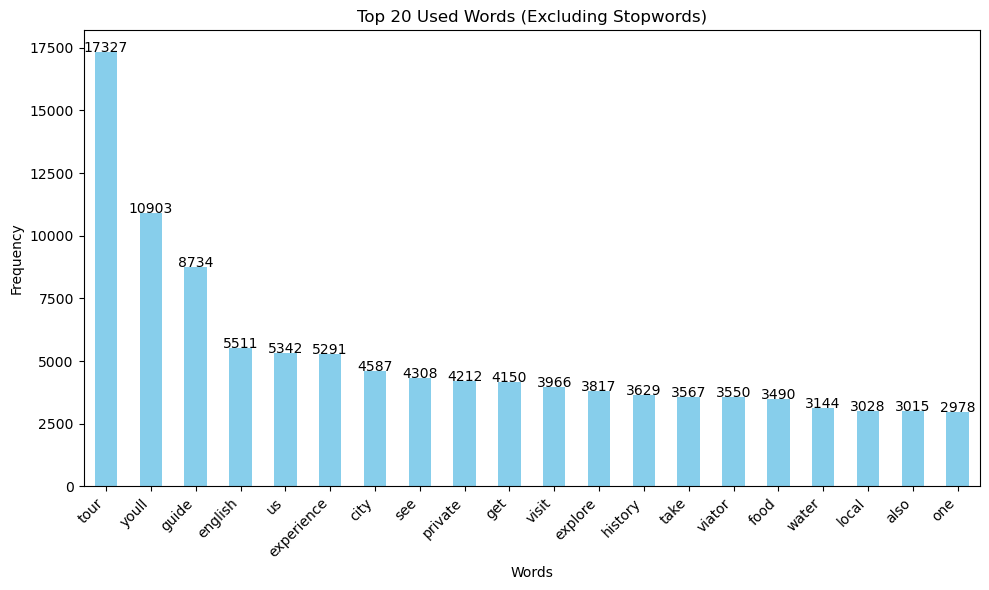

In [85]:

words = df['description'].str.lower().str.findall(r'\b\w+\b').explode()

word_counts = Counter(words)

word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

top20 = word_counts_df.head(20)
plt.figure(figsize=(10, 6))
bars = top20['count'].plot(kind='bar', color='skyblue')
plt.title('Top 20 Used Words (Excluding Stopwords)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

for i, count in enumerate(top20['count']):
    plt.text(i, count + 0.2, str(count), ha='center')

plt.tight_layout()
plt.show()

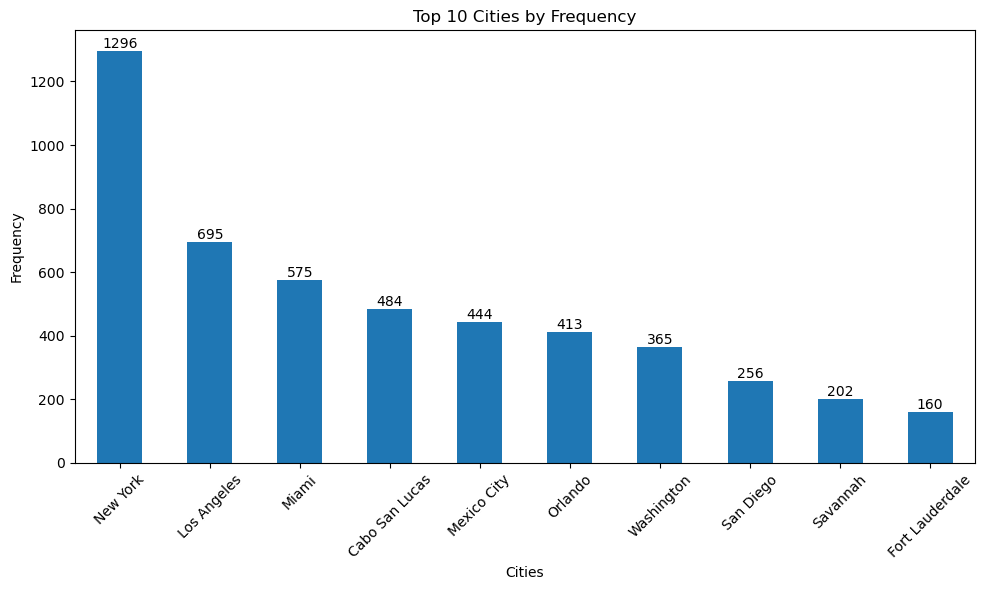

In [86]:
# Assuming df is your DataFrame and 'cities' is the column name
city_counts = df['city'].value_counts().head(10)  # Selecting the top 10 cities

plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar')
plt.title('Top 10 Cities by Frequency')
plt.xlabel('Cities')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Annotate each bar with its frequency
for i, v in enumerate(city_counts):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Preprocessing

In [87]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [88]:
def preprocess_text(text):
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [89]:
df['processed_description'] = df['description'].apply(preprocess_text)

In [90]:
df['processed_description'].value_counts()

processed_description
take worry arrival orlandosanford sfb airport prebook private transf take worry arrival orlandosanford sfb airport prebook private transfer suit group size 8 people avoid long line taxi arrival travel comfort premium car minivan tax vat meet greet service parking andor airport toll private one way transfer tip gratuity excess luggage charge 1 standard suitcase allowed per passenger size 46x69x29cms 18x27x11in additional fee applied case oversized extra luggage                                                                                                                                                                                                                                                                                                                                                                                      63
take worry arrival orlando mco airport prebook private transfer su take worry arrival orlando mco airport prebook private transfer suit g

In [91]:
df.head()

,city,activity,rating,price,link,image_url,location,description,processed_description
0,New York,SUMMIT One Vanderbilt Tickets,4.7,63.57,https://www.booking.com//attractions/us/prcmok...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,SUMMIT One Vanderbilt Tickets45 East 42nd Stre...,Digital art installations views New York skysc...,digital art installation view new york skyscra...
1,New York,9/11 Memorial & Museum Admission,4.8,36.66,https://www.booking.com//attractions/us/prgstb...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,9/11 Memorial & Museum Admission180 Greenwich ...,Chance visit memorial museum thats dedicated 9...,chance visit memorial museum thats dedicated 9...
2,New York,New York CityPASS,4.5,198.23,https://www.booking.com//attractions/us/prj7dh...,https://r-xx.bstatic.com/xdata/images/xphoto/3...,"New York CityPASSNew York, NY, 10036\r",sightseeing pass explore Big Apple attractions...,sightseeing pas explore big apple attraction p...
3,New York,One-hour Sightseeing Yacht Cruise,3.8,21.72,https://www.booking.com//attractions/us/prulfe...,https://q-xx.bstatic.com/xdata/images/xphoto/3...,Departure pointPier 36 New York - Van Gogh Exh...,narrated cruise views Statue Liberty popular a...,narrated cruise view statue liberty popular at...
4,New York,SUMMIT One Vanderbilt Ticket,4.5,63.57,https://www.booking.com//attractions/us/pr3zhw...,https://q-xx.bstatic.com/xdata/images/xphoto/3...,"Departure pointSUMMIT One Vanderbilt, 45 E 42n...",Opportunity go immersive multisensory experien...,opportunity go immersive multisensory experien...


In [92]:
# Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

In [93]:
# Use only the TF-IDF features for prediction, without the price column
X = df['processed_description']
y = df['activity']

In [94]:
df.shape

(8593, 9)

In [95]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train.shape

(6874,)

In [96]:
# Model Training
# Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_tfidf, y_train)

MultinomialNB()

In [97]:
# Model Training
# k-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_tfidf, y_train)

KNeighborsClassifier()

In [98]:
def recommend_activity(input_description, top_n,best_classifier,test_activity):
    processed_input = preprocess_text(input_description)
    input_tfidf = tfidf_vectorizer.transform([processed_input])
    input_features = input_tfidf.toarray()
    
    best_probs = best_classifier.predict_proba(input_features)[0]
    top_indices = np.argsort(best_probs)[::-1][:top_n]
    top_activities = best_classifier.classes_[top_indices]
    top_probs = best_probs[top_indices]
    

    recommendations = []
    for activity, probability in zip(top_activities, top_probs):
        activity = df[df['activity'] == activity]['activity']
        recommendations.append(activity)
        
    for item in recommendations:
        # print(item.iloc[0],"--",test_activity)
        if item.iloc[0] == test_activity:
           return True
    return False


In [99]:
# Model Evaluation
import random
def evaluate_model(classifier, dataframe):
    print("Performance Evaluation:")
    recommendation_count =5
    true_recommendation = 0
    false_recommendation = 0
    count =100
    for index,row in df[:count].iterrows():
        num_words = 10
        input_description = row["processed_description"].split()
        input_description = ' '.join(input_description[0:10])

        res = recommend_activity(input_description,recommendation_count,classifier,row["activity"])
        # print(count,res)
        if res:
            true_recommendation+=1
        else:
            false_recommendation+=1
    accuracy =true_recommendation/count       
    print("Acccuracy: ", accuracy)
    return(accuracy)

In [100]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.shape

(6874, 2)

In [101]:
df_train.head()

,processed_description,activity
6797,explore best washington dc guided 6hour bus wa...,Sight DC with 10+ Stops including Jefferson Me...
1840,chance learn flyboarding experience get chance...,Flyboard Learning Experience
7634,designed tour provide challenging rewarding hi...,Full-Day Guided Adventure in Koko Head Stairs ...
1747,exciting trip everglades unique fascinating pl...,Half Day Everglades Tour with Airboat Ride & B...
1128,guided manhattan tour food tasting twohour gui...,Two-hour Little Italy Food Tour with Breakfast


In [102]:
print("Naive Bayes Classifier:")
nb_score = evaluate_model(nb_classifier, df_train)

print("k-Nearest Neighbors Classifier:")
knn_score = evaluate_model(knn_classifier,df_train)

Naive Bayes Classifier:
Performance Evaluation:
Acccuracy:  0.6
k-Nearest Neighbors Classifier:
Performance Evaluation:
Acccuracy:  0.57


In [103]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test.columns
df_test.head()

,processed_description,activity
4766,perfect mix land water one combo excursion exc...,Guided Trolley Tour and Sightseeing Cruise
6364,ecotour adventure committed best business expe...,Sunrise 4-Hour Grand Teton Wildlife Adventure
1509,guided fishing experience twohour guided tour ...,Two-hour Pier Fishing Experience
7379,chance connect nature visit community native o...,"Coffee, Chocolate, Mezcal and Waterfalls Tour"
6355,well begin adventure marina smooth check frien...,Islas Marietas Experience! Catamaran Nature Trip


In [104]:
print("Naive Bayes Classifier:")
evaluate_model(nb_classifier, df_test)

print("k-Nearest Neighbors Classifier:")
evaluate_model(knn_classifier,df_test)

Naive Bayes Classifier:
Performance Evaluation:
Acccuracy:  0.6
k-Nearest Neighbors Classifier:
Performance Evaluation:
Acccuracy:  0.57


0.57

In [64]:
# Recommendation using the best model
if knn_score > nb_score:
    best_classifier = knn_classifier
else:
    best_classifier = nb_classifier

In [65]:
print(best_classifier)

MultinomialNB()


In [66]:
# from sklearn.model_selection import GridSearchCV

# # Hyperparameter Tuning
# param_grid = {'clf__alpha': (0.1, 0.5, 1)}
# model = MultinomialNB()
# grid_search = GridSearchCV(model, param_grid, cv=5)
# print(X_tfidf[:-4].shape, y_train[:-4].shape)
# X_tfidf= X_tfidf[:-4]
# y_train = y_train[:-4]
# print(X_tfidf.shape, y_train.shape)
# grid_search.fit(X_tfidf, y_train)

# # Get the best model
# best_classifier = grid_search.best_estimator_



In [67]:
from sklearn.metrics import precision_score, recall_score
def recommend_city(input_description, top_n=5):
    processed_input = preprocess_text(input_description)
    input_tfidf = tfidf_vectorizer.transform([processed_input])
    input_features = input_tfidf.toarray()
    
    best_probs = best_classifier.predict_proba(input_features)[0]
    top_indices = np.argsort(best_probs)[::-1][:top_n]
    top_cities = best_classifier.classes_[top_indices]
    top_probs = best_probs[top_indices]
    
    
    # print(top_cities)
    recommendations = []
    for activity, probability in zip(top_cities, top_probs):
        city = df[df['activity'] == activity]['city']
        try:
            location = df[df['activity'] == activity]['location']
        except KeyError:
            location = "Location not available"
            
        try:
            link = df[df['activity'] == activity]['link']
        except KeyError:
            link = "url not available"
        recommendations.append((activity, probability, city, location,link))
        
    return recommendations


In [68]:
input_description = "digital art"

In [69]:
recommendations = recommend_city(input_description)

print("Top 5 recommended cities:")
for activity, probability, city, location,link in recommendations:
    print(f"Activity: {activity} City: {city}\n")

Top 5 recommended cities:
Activity: Superblue Miami with teamLab City: 1750    Miami
Name: city, dtype: object

Activity: SUMMIT One Vanderbilt Tickets City: 0    New York
Name: city, dtype: object

Activity: Brooklyn Graffiti Lesson City: 266    New York
Name: city, dtype: object

Activity: Metropolitan Museum of Art Self-guided Audio Tour City: 53    New York
Name: city, dtype: object

Activity: Cleveland Scavenger Hunt Tour City: 8486    Cleveland
Name: city, dtype: object



Using LSTM

In [70]:
descriptions = X
activity_names = y

# Tokenize the descriptions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(descriptions)

max_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

label_dict = {activity: i for i, activity in enumerate(activity_names)}
labels = np.array([label_dict[activity] for activity in activity_names])

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_len))
model.add(LSTM(100))
model.add(Dense(len(activity_names), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(type(X_train), type(y_train))

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')



<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1/10


215/215 [==============================] - 98s 444ms/step - loss: 9.1126 - accuracy: 0.0000e+00 - val_loss: 9.1882 - val_accuracy: 0.0000e+00
Epoch 2/10
215/215 [==============================] - ETA: 0s - loss: 9.0294 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [133]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
import webbrowser

class RecommendationApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Travel Recommendation App")
        self.master.geometry("800x600")
        self.master.resizable(False, False)

        self.label = ttk.Label(master, text="Enter your description:")
        self.label.grid(row=0, column=0, padx=10, pady=10, sticky="w")

        self.input_entry = ttk.Entry(master, width=130)
        self.input_entry.grid(row=1, column=0, padx=10, pady=5)

        self.recommend_button = ttk.Button(master, text="Recommend", command=self.show_recommendations)
        self.recommend_button.grid(row=2, column=0, padx=10, pady=5)

        self.output_text = tk.Text(master, height=25, width=50)
        self.output_text.grid(row=3, column=0, padx=10, pady=10, sticky="ew")
        self.output_text.tag_configure("link", foreground="blue", underline=True)
        self.output_text.tag_bind("link", "<Button-1>", self.on_link_click)

    def show_recommendations(self):
        input_description = self.input_entry.get()
        if input_description:
            try:
                recommendations = recommend_city(input_description)
                self.output_text.delete(1.0, tk.END)
                self.output_text.insert(tk.END, "Top 5 recommended cities:\n")
                self.output_text.insert(tk.END, f"{'City':<30}{'Activity':<30}\n")
                for activity, probability, city, location, link in recommendations:
                    city_text = f"City: {city.iloc[0]:<20}, Activity: {activity:<30}\n"
                    city_link =""
                    self.output_text.insert(tk.END, city_text)
                    self.output_text.insert(tk.END, city_link, "link")
                    self.output_text.insert(tk.END, f"Link: {link.iloc[0]}\n\n", "link")

            except Exception as e:
                messagebox.showerror("Error", str(e))
        else:
            messagebox.showwarning("Warning", "Please enter a description.")

    def on_link_click(self, event):
        index = self.output_text.index("@%s,%s" % (event.x, event.y))
        tag = self.output_text.tag_names(index)
        if "link" in tag:
            link_start = self.output_text.search("Link: ", index, backwards=True, regexp=True)
            if link_start:
                link_start = link_start + "+6c"
                link_end = self.output_text.search("\n", link_start)
                if link_end:
                    link = self.output_text.get(link_start, link_end)
                    webbrowser.open_new(link)

def main():
    root = tk.Tk()
    app = RecommendationApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()


['‘Rogue: The Sexiest Show in Vegas’ Theatre Tickets'
 'Guided Clear Kayak Eco-Tour Near Key West'
 'Guided Day Tour to Hoover Dam and Grand Canyon'
 'Guided Day Tour with Food Tastings'
 'Guided Day Trip to Cholula and Puebla']
